<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper Functions</a></span></li></ul></div>

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
import tensorflow
import keras
from keras import backend as K
import numpy as np
from imblearn.over_sampling import SMOTE
from keras.constraints import max_norm
from keras.optimizers import Adam
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from keras.layers import Dropout
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers.recurrent import LSTM
from keras.layers import Flatten

import time
import tensorflow as tf
from sklearn.metrics import f1_score,roc_auc_score, log_loss, confusion_matrix

import seaborn as sns
from collections import Counter
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
%run "../../src/data_preparation/utils.py"

print(get_notebook_kernel_id())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3818443488363419559
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3682381886928694082
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12855850927457142624
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10911298356
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4832414580829589422
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]
d4fa0f59-a392-40a1-840d-6200044c9e59


## Helper Functions

In [74]:
## define metrics

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [75]:
## tune the threshold for f1-score
def find_thres(y_true, y_test_pred_prob):
    thres = 0.1
    thres_max = f1_max = 0
    while True:
        y_pred = list(y_test_pred_prob > thres)
        f1 = f1_score(y_true, y_pred, average='binary', labels=[0, 1])
        if f1 > f1_max:
            f1_max = f1
            thres_max = thres
            
        thres+=0.01
        if thres >= 1:
            break
            
    y_pred = list(y_test_pred_prob > thres_max) 
    if sum(y_pred) == 0:
        print("Just 1 class")
    else:
        count_test = Counter(y_pred)
        print(count_test, count_test[1]*100/count_test[0])
        log_loss_error = log_loss(list(y_true), list(y_test_pred_prob), eps = 1e-7)

        # Evaluate the predictions
        scores = confusion_matrix(y_true, y_pred).ravel()
        tn, fp, fn, tp = scores
        print('TN:{}    FP:{}    FN:{}    TP:{}'.format(tn, fp, fn, tp))
        f1 = f1_score(y_true, y_pred, average='binary', labels=[0, 1])
        print('f1-score = {}'.format(f1))

        print("log loss error:", log_loss_error)
    
    return (thres_max, f1_max)

In [136]:
def create_model():
    nn = Sequential()
    nn.add(LSTM(80, batch_input_shape=(64,11,20), return_sequences=True, recurrent_dropout = 0.1))
    nn.add(LSTM(60, recurrent_dropout = 0.2))
    nn.add(Dropout(0.2))
    nn.add(Dense(40, activation='relu'))
    nn.add(Dropout(0.2))
    nn.add(Dense(10, activation='relu'))
    nn.add(Dense(1))
    nn.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[f1])

In [137]:
## reformat input data to put in LSTM
def create_data(df, time_steps = 60, seq_len = 25):
    data = df.values
    X = np.reshape(data, (len(df) // time_steps, time_steps, seq_len))
    return X

In [11]:
## read processed data 
fold1 = pd.read_pickle("../../data/processed/fold1_norm_new.pkl")
fold2 = pd.read_pickle("../../data/processed/fold2_norm_new.pkl")
fold3 = pd.read_pickle("../../data/processed/fold3_norm_new.pkl")
fold_submission = pd.read_pickle("../../data/processed/fold_submission_norm_new.pkl")

In [12]:
## names of 25 variables
feature_cols = ['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE', 'XR_MAX']

In [38]:
## concat fold1 and fold2 as train set, fold 3 as valid set
fold1["id_"] =  fold1.ID.values
fold2["id_"] =  fold2.ID.values + max (fold1.ID.values)
train_final = pd.concat([fold1, fold2]).reset_index(drop=True)
valid_final = fold3

In [41]:
## create input data for LSTM

X_train_final, y_train_final =  create_data(train_final[feature_cols].fillna(0), time_steps = 60, seq_len = 25),  train_final.drop_duplicates(subset=["id_", "LABEL"]).LABEL.values
X_valid_final, y_valid_final =  create_data(valid_final[feature_cols].fillna(0), time_steps = 60, seq_len = 25),  valid_final.drop_duplicates(subset=["ID", "LABEL"]).LABEL.values
X_submission = create_data(fold_submission[feature_cols].fillna(0), time_steps = 60, seq_len = 25)

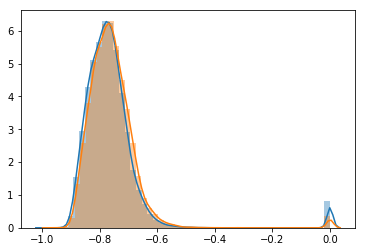

In [22]:
## check some distributions, make sure the distributions are similar on train and valid sets
sns.distplot(X_train_final[:,1,15])
sns.distplot(X_valid_final[:,1,15])

In [23]:
now = datetime.now()
log_dir = "../tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
timesteps = 60
num_features = 25

In [78]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60, 64)            23040     
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 30728     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 53,777
Trainable params: 53,777
Non-trainable params: 0
_________________________________________________________________


In [79]:
## Training
    
random_seed = 912
early_stop = 20
num_epoch = 200
class_weight=  {0 : 1 , 1: 1}


t_start = time.time()
print("...running")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_f1', min_delta=0,
                                                patience=early_stop, verbose=0, mode='max', baseline=None)
mcp_save = keras.callbacks.ModelCheckpoint('LSTM_', save_best_only=True, monitor='val_f1', mode='max')

callback_list = [tensorboard_callback, early_stopping_callback, mcp_save]

model.fit(x=X_train_final, y=y_train_final, batch_size=128, 
          epochs=num_epoch, verbose=1, validation_data=(X_valid_final, y_valid_final),
          shuffle=True, callbacks=callback_list, class_weight=class_weight )

model.load_weights(filepath = 'LSTM_')
val_loss = model.evaluate(X_valid_final, y_valid_final)

print(val_loss)
t_end = time.time()
print("running time = ", t_end-t_start)

...running
Train on 169254 samples, validate on 27006 samples
Epoch 1/200
169254/169254 [==============================] - 149s 883us/step - loss: 0.4857 - f1: 0.2643 - val_loss: 0.2946 - val_f1: 0.6112
Epoch 2/200
169254/169254 [==============================] - 149s 880us/step - loss: 0.2880 - f1: 0.5045 - val_loss: 0.2777 - val_f1: 0.5970
Epoch 3/200
169254/169254 [==============================] - 150s 884us/step - loss: 0.2787 - f1: 0.5224 - val_loss: 0.2754 - val_f1: 0.6706
Epoch 4/200
169254/169254 [==============================] - 149s 881us/step - loss: 0.2719 - f1: 0.5322 - val_loss: 0.2842 - val_f1: 0.6735
Epoch 5/200
169254/169254 [==============================] - 149s 880us/step - loss: 0.2712 - f1: 0.5309 - val_loss: 0.2739 - val_f1: 0.6757
Epoch 6/200
169254/169254 [==============================] - 149s 879us/step - loss: 0.2686 - f1: 0.5440 - val_loss: 0.2687 - val_f1: 0.6878
Epoch 7/200
169254/169254 [==============================] - 149s 882us/step - loss: 0.2672 

In [80]:
y_valid_final_pred_prob = model.predict(X_valid_final, )[:,0]
log_loss(list(y_valid_final), list(y_valid_final_pred_prob), eps = 1e-7)

0.2747421436463029

In [81]:
y_valid_final_pred_prob

array([0.79274505, 0.05656287, 0.00235994, ..., 0.7111133 , 0.00224386,
       0.02895459], dtype=float32)

In [133]:
valid_df = pd.DataFrame(data={"pred_LSTM": (y_valid_final_pred_prob), "label_LSTM": y_valid_final})
valid_df.label_LSTM = valid_df.label_LSTM.astype(int)
valid_df.to_csv("../../data/intermediate/LSTM_62000.csv", index=False)
print(valid_df.shape)
valid_df.head()

(27006, 2)


,pred_LSTM,label_LSTM
0,0.792745,1
1,0.056563,0
2,0.002360,0
3,0.003632,0
4,0.061996,0


In [82]:
y_submission_pred_prob = model.predict(X_submission)[:,0]

In [83]:
y_submission_pred_prob

array([0.00503083, 0.03582081, 0.00231088, ..., 0.00217863, 0.00260129,
       0.00379758], dtype=float32)

In [135]:
submit_prob_df = pd.DataFrame(data={"pred_LSTM": (y_submission_pred_prob), "label_LSTM":  [np.nan]*len(y_submission_pred_prob)})
submit_prob_df.to_csv("../../data/intermediate/LSTM_62000_sub_thres0.37.csv", index=False)
print(submit_prob_df.shape)
submit_prob_df.head()

(173512, 2)


,pred_LSTM,label_LSTM
0,0.005031,NaN
1,0.035821,NaN
2,0.002311,NaN
3,0.123103,NaN
4,0.003109,NaN


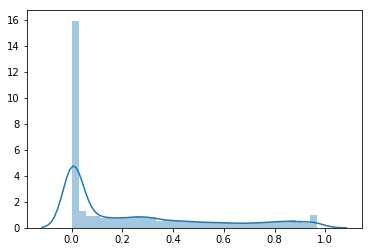

In [84]:
sns.distplot(y_valid_final_pred_prob)

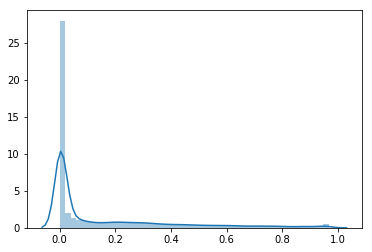

In [85]:
sns.distplot(y_submission_pred_prob)

In [86]:
Counter(y_valid_final)

Counter({1.0: 4770, 0.0: 22236})

In [87]:
find_thres(y_valid_final, y_valid_final_pred_prob)

/home/zdeploy/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Counter({False: 21238, True: 5768}) 27.15886618325643
TN:20240    FP:1996    FN:998    TP:3772
f1-score = 0.7158853672423611
log loss error: 0.2747421436463029


(0.4900000000000003, 0.7158853672423611)

In [88]:
thes = 0.5
y_true = y_valid_final
y_test_pred_prob = y_valid_final_pred_prob


y_pred = list(y_test_pred_prob > thes)
if sum(y_pred) == 0:
    print("Just 1 class")
else:
    count_test = Counter(y_pred)
    print(count_test, count_test[1]*100/count_test[0])
    log_loss_error = log_loss(list(y_true), list(y_test_pred_prob), eps = 1e-7)

    # Evaluate the predictions
    scores = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = scores
    print('TN:{}    FP:{}    FN:{}    TP:{}'.format(tn, fp, fn, tp))
    f1 = f1_score(y_true, y_pred, average='binary', labels=[0, 1])
    print('f1-score = {}'.format(f1))

    print("log loss error:", log_loss_error)

Counter({False: 21353, True: 5653}) 26.474031751978643
TN:20312    FP:1924    FN:1041    TP:3729
f1-score = 0.7155329559627747
log loss error: 0.2747421436463029


In [129]:
thes = 0.37
y_test_pred_prob = y_submission_pred_prob


y_pred = list(y_test_pred_prob > thes)
if sum(y_pred) == 0:
    print("Just 1 class")
else:
    count_test = Counter(y_pred)
    print(count_test, count_test[1]*100/count_test[0])
    
    print(sum(_713.ClassLabel == y_pred) * 100/len(y_pred))

Counter({False: 144339, True: 29173}) 20.21144666375685
93.49266909493292


In [130]:
#### SUBMISSION
submission_df = pd.DataFrame({"Id": range(1, len(y_pred)+1), "ClassLabel": list(y_pred)})
print(Counter(submission_df.ClassLabel))
submission_df.ClassLabel = submission_df.ClassLabel.astype(int)
submission_df.to_csv("../../data/output/LSTM_norm_{}_{}.csv".format(str(f1), thes), index=False)
submission_df.tail(10)


Counter({False: 144339, True: 29173})


,Id,ClassLabel
173502,173503,1
173503,173504,0
173504,173505,0
173505,173506,0
173506,173507,0
173507,173508,1
173508,173509,1
173509,173510,0
173510,173511,0
173511,173512,0


In [94]:
Counter(submission_df.ClassLabel)

Counter({0: 144762, 1: 28750})